In [1]:
%matplotlib inline

https://keras.io/zh/optimizers/

調整Optimizer

import scipy.misc
dir(scipy.misc)

# 大藝術家(keras+tensorflow)

## 測試於tensorflow 1.10 keras 2.2.2

Style Transfer是機器視覺中非常有趣的新應用，它是透過預訓練過的模型作為特徵抽取器，所謂的風格就是底層特徵的筆觸、質地、渲染以及高層次的結構、光影，透過重建內容與重建風格兩種不同的損失函數組合，就構成了有風格圖的內容，卻保留內容圖的物體的精采生成畫面。在本次實作中我們將會來介紹如何使用keras+tensorflow來完成格移轉。

![style transfer](../Images/styletransfer.png)

首先先引用需要的包

In [2]:
#from __future__ import print_function
#https://ithelp.ithome.com.tw/users/20120156/ironman/2335?page=1
import time
from PIL import Image
import numpy as np
import tensorflow as tf
from keras import backend
from keras.models import Model
from keras.applications.vgg16 import VGG16
from keras.backend.tensorflow_backend import set_session
from scipy.optimize import fmin_l_bfgs_b
from scipy.misc import imsave


#如果你使用tensorflow+keras總是異常掛掉，請務必加入以下語法(貪心的tf把所有gpu全吃光一點不留給keras，變成全掛的慘劇)
config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 1
config.gpu_options.visible_device_list = "0"
config.gpu_options.allow_growth = True
config.gpu_options.allocator_type = 'BFC'
config.gpu_options.per_process_gpu_memory_fraction = 0.90   #限制記憶體內容
set_session(tf.Session(config=config))

run_opts = tf.RunOptions(report_tensor_allocations_upon_oom = True)

C:\Users\Richard\anaconda3\envs\formal\lib\site-packages\tensorflow\python\framework\dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\Richard\anaconda3\envs\formal\lib\site-packages\tensorflow\python\framework\dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\Richard\anaconda3\envs\formal\lib\site-packages\tensorflow\python\framework\dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\Richard\anaconda3\envs\formal\lib\site-packages\tensorf

在此為各位準備了9種風格圖(左上至右下，分別為style1.jpg~style9.jpg)

![style all](../Images/style_all.jpg)

首先我們來看看這次的內容圖

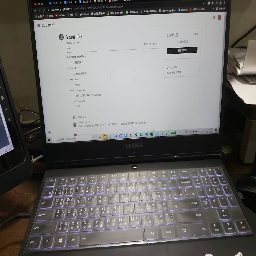

In [25]:
height=256
width=256
content_weight = 0.00001   #0.025
style_weight = 5.0   #5.0
total_variation_weight = 1.0  #1.0

content_path = 'images/14.jpg'
content_image=Image.open( content_path).resize((256,256))
content_image

我挑選了最有趣的風格圖

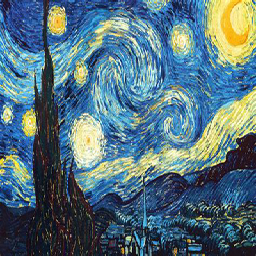

In [26]:
style_path = 'Images/0.8.jpg'
style_image=Image.open(style_path).resize((256,256))
style_image

圖片需要稍做處理，轉換為向量，設計批次軸，以及減去rgb各自的均值

In [27]:

content_array = np.asarray(content_image, dtype='float32')
content_array = np.expand_dims(content_array, axis=0)
print(content_array.shape)

style_array = np.asarray(style_image, dtype='float32')
style_array = np.expand_dims(style_array, axis=0)
print(style_array.shape)
print('content_array',content_array)
#Change the ordering of array from RGB to BGR 
content_array[:, :, :, 0] -= 103.939
content_array[:, :, :, 1] -= 116.779
content_array[:, :, :, 2] -= 123.68
content_array = content_array[:, :, :, ::-1]
print('content_array',content_array)
style_array[:, :, :, 0] -= 103.939
style_array[:, :, :, 1] -= 116.779
style_array[:, :, :, 2] -= 123.68
style_array = style_array[:, :, :, ::-1]
'''
#轉換成 VGG 16 input 格式
#1.轉換為向量
content_array = np.asarray(content_image, dtype='float32')
print(content_array.shape)
#2.設計批次軸(增加一个维度)
content_array = np.expand_dims(content_array, axis=0)
print(content_array.shape)

style_array = np.asarray(style_image, dtype='float32')
style_array = np.expand_dims(style_array, axis=0)
print(style_array.shape)

#3.減去rgb各自的均值
#https://www.zhihu.com/question/49096923
#标准化数据通过减去均值然后除以方差（或标准差），这种数据标准化方法经过处理后数据符合标准正态分布，
#即均值为0，标准差为1，转化函数为：x =(x -  mean ) / std 从经验上说，归一化是让不同维度之间的特征在数值上有一定比较性，
#可以大大提高分类器的准确性。

# 設定RGB顏色的中心點 (Remove zero-center by mean pixel)
content_array[:, :, :, 0] -= 103.939
content_array[:, :, :, 1] -= 116.779
content_array[:, :, :, 2] -= 123.68
# 'BGR'->'RGB'
content_array = content_array[:, :, :, ::-1]

style_array[:, :, :, 0] -= 103.939
style_array[:, :, :, 1] -= 116.779
style_array[:, :, :, 2] -= 123.68
style_array = style_array[:, :, :, ::-1]
'''

(1, 256, 256, 3)
(1, 256, 256, 3)
content_array [[[[55. 48. 30.]
   [55. 48. 30.]
   [55. 48. 30.]
   ...
   [89. 81. 62.]
   [89. 81. 62.]
   [87. 78. 61.]]

  [[55. 48. 30.]
   [55. 48. 30.]
   [55. 48. 30.]
   ...
   [90. 82. 63.]
   [88. 80. 61.]
   [89. 80. 63.]]

  [[54. 47. 29.]
   [57. 50. 32.]
   [57. 50. 32.]
   ...
   [89. 81. 62.]
   [88. 80. 61.]
   [89. 80. 63.]]

  ...

  [[67. 45. 21.]
   [68. 42. 19.]
   [71. 40. 19.]
   ...
   [43. 44. 39.]
   [44. 45. 40.]
   [45. 44. 40.]]

  [[64. 42. 18.]
   [64. 38. 15.]
   [67. 36. 15.]
   ...
   [45. 46. 41.]
   [45. 46. 41.]
   [47. 46. 42.]]

  [[66. 40. 17.]
   [66. 40. 17.]
   [64. 38. 15.]
   ...
   [46. 47. 42.]
   [46. 47. 42.]
   [47. 46. 42.]]]]
content_array [[[[ -93.68      -68.779     -48.939003]
   [ -93.68      -68.779     -48.939003]
   [ -93.68      -68.779     -48.939003]
   ...
   [ -61.68      -35.779     -14.939003]
   [ -61.68      -35.779     -14.939003]
   [ -62.68      -38.779     -16.939003]]

  [[ -93.

"\n#轉換成 VGG 16 input 格式\n#1.轉換為向量\ncontent_array = np.asarray(content_image, dtype='float32')\nprint(content_array.shape)\n#2.設計批次軸(增加一个维度)\ncontent_array = np.expand_dims(content_array, axis=0)\nprint(content_array.shape)\n\nstyle_array = np.asarray(style_image, dtype='float32')\nstyle_array = np.expand_dims(style_array, axis=0)\nprint(style_array.shape)\n\n#3.減去rgb各自的均值\n#https://www.zhihu.com/question/49096923\n#标准化数据通过减去均值然后除以方差（或标准差），这种数据标准化方法经过处理后数据符合标准正态分布，\n#即均值为0，标准差为1，转化函数为：x =(x -  mean ) / std 从经验上说，归一化是让不同维度之间的特征在数值上有一定比较性，\n#可以大大提高分类器的准确性。\n\n# 設定RGB顏色的中心點 (Remove zero-center by mean pixel)\ncontent_array[:, :, :, 0] -= 103.939\ncontent_array[:, :, :, 1] -= 116.779\ncontent_array[:, :, :, 2] -= 123.68\n# 'BGR'->'RGB'\ncontent_array = content_array[:, :, :, ::-1]\n\nstyle_array[:, :, :, 0] -= 103.939\nstyle_array[:, :, :, 1] -= 116.779\nstyle_array[:, :, :, 2] -= 123.68\nstyle_array = style_array[:, :, :, ::-1]\n"

定義輸入變數

In [28]:
## 設定 Keras 變數 原圖向量
content_image = backend.variable(content_array)
# 設定 Keras 變數 風格圖向量
style_image = backend.variable(style_array)
# 設定合成圖的起始值
combination_image = backend.placeholder((1, height, width, 3))




print('combination_image',combination_image)
input_tensor = backend.concatenate([content_image,
                                    style_image,
                                    combination_image], axis=0)
#Finally, we concatenate all this image data into a single tensor which is suitable for processing by Keras VGG16 model.
print('input_tensor',input_tensor)

combination_image Tensor("Placeholder_54:0", shape=(1, 256, 256, 3), dtype=float32)
input_tensor Tensor("concat_2:0", shape=(3, 256, 256, 3), dtype=float32)


由於vgg模型已經讀取過Imagenet的百萬張圖片，因此我們可以透過預訓練好的Vgg16模型的不同神經層來為我們解析指定圖片的視覺特徵。

In [29]:
# 載入 VGG 19 模型，不包括加在最後3層的卷積層
model = VGG16(input_tensor=input_tensor, weights='imagenet',
              include_top=False)
model.summary()  #vgg架構
layers = dict([(layer.name, layer.output) for layer in model.layers])
layers

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, None, None, 3)     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0         
__________

{'input_3': <tf.Tensor 'concat_2:0' shape=(3, 256, 256, 3) dtype=float32>,
 'block1_conv1': <tf.Tensor 'block1_conv1_2/Relu:0' shape=(3, 256, 256, 64) dtype=float32>,
 'block1_conv2': <tf.Tensor 'block1_conv2_2/Relu:0' shape=(3, 256, 256, 64) dtype=float32>,
 'block1_pool': <tf.Tensor 'block1_pool_2/MaxPool:0' shape=(3, 128, 128, 64) dtype=float32>,
 'block2_conv1': <tf.Tensor 'block2_conv1_2/Relu:0' shape=(3, 128, 128, 128) dtype=float32>,
 'block2_conv2': <tf.Tensor 'block2_conv2_2/Relu:0' shape=(3, 128, 128, 128) dtype=float32>,
 'block2_pool': <tf.Tensor 'block2_pool_2/MaxPool:0' shape=(3, 64, 64, 128) dtype=float32>,
 'block3_conv1': <tf.Tensor 'block3_conv1_2/Relu:0' shape=(3, 64, 64, 256) dtype=float32>,
 'block3_conv2': <tf.Tensor 'block3_conv2_2/Relu:0' shape=(3, 64, 64, 256) dtype=float32>,
 'block3_conv3': <tf.Tensor 'block3_conv3_2/Relu:0' shape=(3, 64, 64, 256) dtype=float32>,
 'block3_pool': <tf.Tensor 'block3_pool_2/MaxPool:0' shape=(3, 32, 32, 256) dtype=float32>,
 'blo

# # 內容損失

In [30]:
# 彙總 風格 loss content_loss total_variation_loss 的損失(loss)
loss = backend.variable(0.)

def content_loss(content, combination):
    return backend.sum(backend.square(combination - content))

#layer_features = layers['block2_conv2']       #風格架構
#layer_features = layers['block4_conv1']
layer_features = layers['block4_conv1']

content_image_features = layer_features[0, :, :, :]
combination_features = layer_features[2, :, :, :]

loss += content_weight * content_loss(content_image_features,
                                      combination_features)



# # 風格損失

In [31]:
def gram_matrix(x):    #將特徵圖乘上轉90度特徵圖 用來打散特徵
    features = backend.batch_flatten(backend.permute_dimensions(x, (2, 0, 1)))
    gram = backend.dot(features, backend.transpose(features))
    return gram

def style_loss(style, combination):
    S = gram_matrix(style)
    C = gram_matrix(combination)
    channels = 3
    size = height * width
    return backend.sum(backend.square(S - C)) / (4. * (channels ** 2) * (size ** 2))

feature_layers = ['block1_conv2', 'block2_conv2',
                  'block3_conv3', 'block4_conv3',
                  'block5_conv3']           #風格架構

for layer_name in feature_layers:
    layer_features = layers[layer_name]
    style_features = layer_features[1, :, :, :]
    combination_features = layer_features[2, :, :, :]
    sl = style_loss(style_features, combination_features)
    loss += (style_weight / len(feature_layers)) * sl

# # 總體變動損失

In [32]:
def total_variation_loss(x):
    a = backend.pow(x[:, :height-1, :width-1, :] - x[:, 1:, :width-1, :],2)
    b = backend.pow(x[:, :height-1, :width-1, :] - x[:, :height-1, 1:, :],2)
    return backend.sum(backend.pow(a + b, 1.25))


loss += total_variation_weight * total_variation_loss(combination_image)


定義損失函數與梯度下降

In [33]:
grads = backend.gradients(loss, combination_image) #梯度下降
outputs = [loss]
outputs += grads
f_outputs = backend.function([combination_image], outputs)

def eval_loss_and_grads(x):
    x = x.reshape((1, height, width, 3))
    outs = f_outputs([x])
    loss_value = outs[0]
    grad_values = outs[1].flatten().astype('float64')
    return loss_value, grad_values

class Evaluator(object):

    def __init__(self):
        self.loss_value = None
        self.grads_values = None

    def loss(self, x):
        assert self.loss_value is None
        loss_value, grad_values = eval_loss_and_grads(x)
        self.loss_value = loss_value
        self.grad_values = grad_values
        return self.loss_value

    def grads(self, x):
        assert self.loss_value is not None
        grad_values = np.copy(self.grad_values)
        self.loss_value = None
        self.grad_values = None
        return grad_values

evaluator = Evaluator()


輸入內容圖跑10次

In [34]:
import matplotlib.pyplot as plt
x =content_array

iterations = 20      #輸入內容圖跑1次
#https://blog.csdn.net/C_chuxin/article/details/103880703
for i in range(iterations):
    print('Start of iteration', i)
    start_time = time.time()
    x, min_val, info = fmin_l_bfgs_b(evaluator.loss, x.flatten(), fprime=evaluator.grads, maxfun=10)
    print('Current loss value:', min_val)
    end_time = time.time()
    print('Iteration %d completed in %ds' % (i, end_time - start_time))


Start of iteration 0
Current loss value: 116155250000.0
Iteration 0 completed in 1s
Start of iteration 1
Current loss value: 34798776000.0
Iteration 1 completed in 0s
Start of iteration 2
Current loss value: 14347667000.0
Iteration 2 completed in 0s
Start of iteration 3
Current loss value: 8701536000.0
Iteration 3 completed in 0s
Start of iteration 4
Current loss value: 6443260000.0
Iteration 4 completed in 0s
Start of iteration 5
Current loss value: 5075471000.0
Iteration 5 completed in 0s
Start of iteration 6
Current loss value: 4297219600.0
Iteration 6 completed in 0s
Start of iteration 7
Current loss value: 3945960000.0
Iteration 7 completed in 0s
Start of iteration 8
Current loss value: 3524501000.0
Iteration 8 completed in 0s
Start of iteration 9
Current loss value: 3271593500.0
Iteration 9 completed in 0s
Start of iteration 10
Current loss value: 2985681200.0
Iteration 10 completed in 0s
Start of iteration 11
Current loss value: 2796994300.0
Iteration 11 completed in 0s
Start of

看看結果是不是很有趣呢?

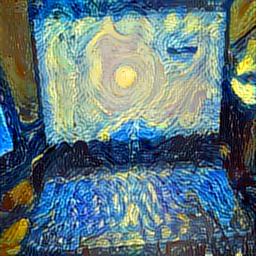

In [35]:

x = x.reshape((height, width, 3))
x = x[:, :, ::-1]
x[:, :, 0] += 103.939
x[:, :, 1] += 116.779
x[:, :, 2] += 123.68
x = np.clip(x, 0, 255).astype('uint8')

img=Image.fromarray(x)
img.save('images/pic100.jpg')
img